### **Notebook 1: Utility, Worth Function, and Core Determination**

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from tqdm import tqdm
import scipy.stats as stats

In [2]:
from util_conversion import SudanUtil,EthUtil,EgyptUtil,egypt_HAD_util

In [3]:
module_path = os.path.abspath(os.path.join("../model/"))
if module_path not in sys.path:
    sys.path.append(module_path)

from model_nile import ModelNile
from data_generation import generate_input_data

#### **Utility Sensitivity Analysis**

##### 1. Analysis for Egypt Utility Function

100%|██████████| 4368/4368 [00:02<00:00, 2118.86it/s]


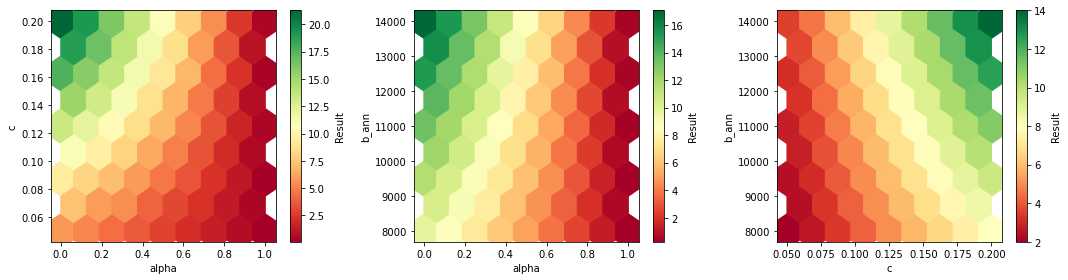

In [4]:
#testing the HAD utility function
#variables are: alpha(ratio of time spend underneath the HAD minimum level), cost_hp

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol 
from sensitivity import SensitivityAnalyzer

def EgHADfuc(alpha,c,b_ann): #return function
    return ((1-alpha) * b_ann * 1000000 * c) / 1e8

sensitivity_dict = {
    'alpha': [0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.9,0.95,1],
    'c': [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20],
    'b_ann': [8000,8500,9000,9500,10000,10500,11000,11500,12000,12500,13000,13500,14000]
}

sa = SensitivityAnalyzer(sensitivity_dict, EgHADfuc)
plot = sa.plot()
#styled_df = sa.styled_dfs();

100%|██████████| 576000/576000 [17:54<00:00, 536.14it/s]


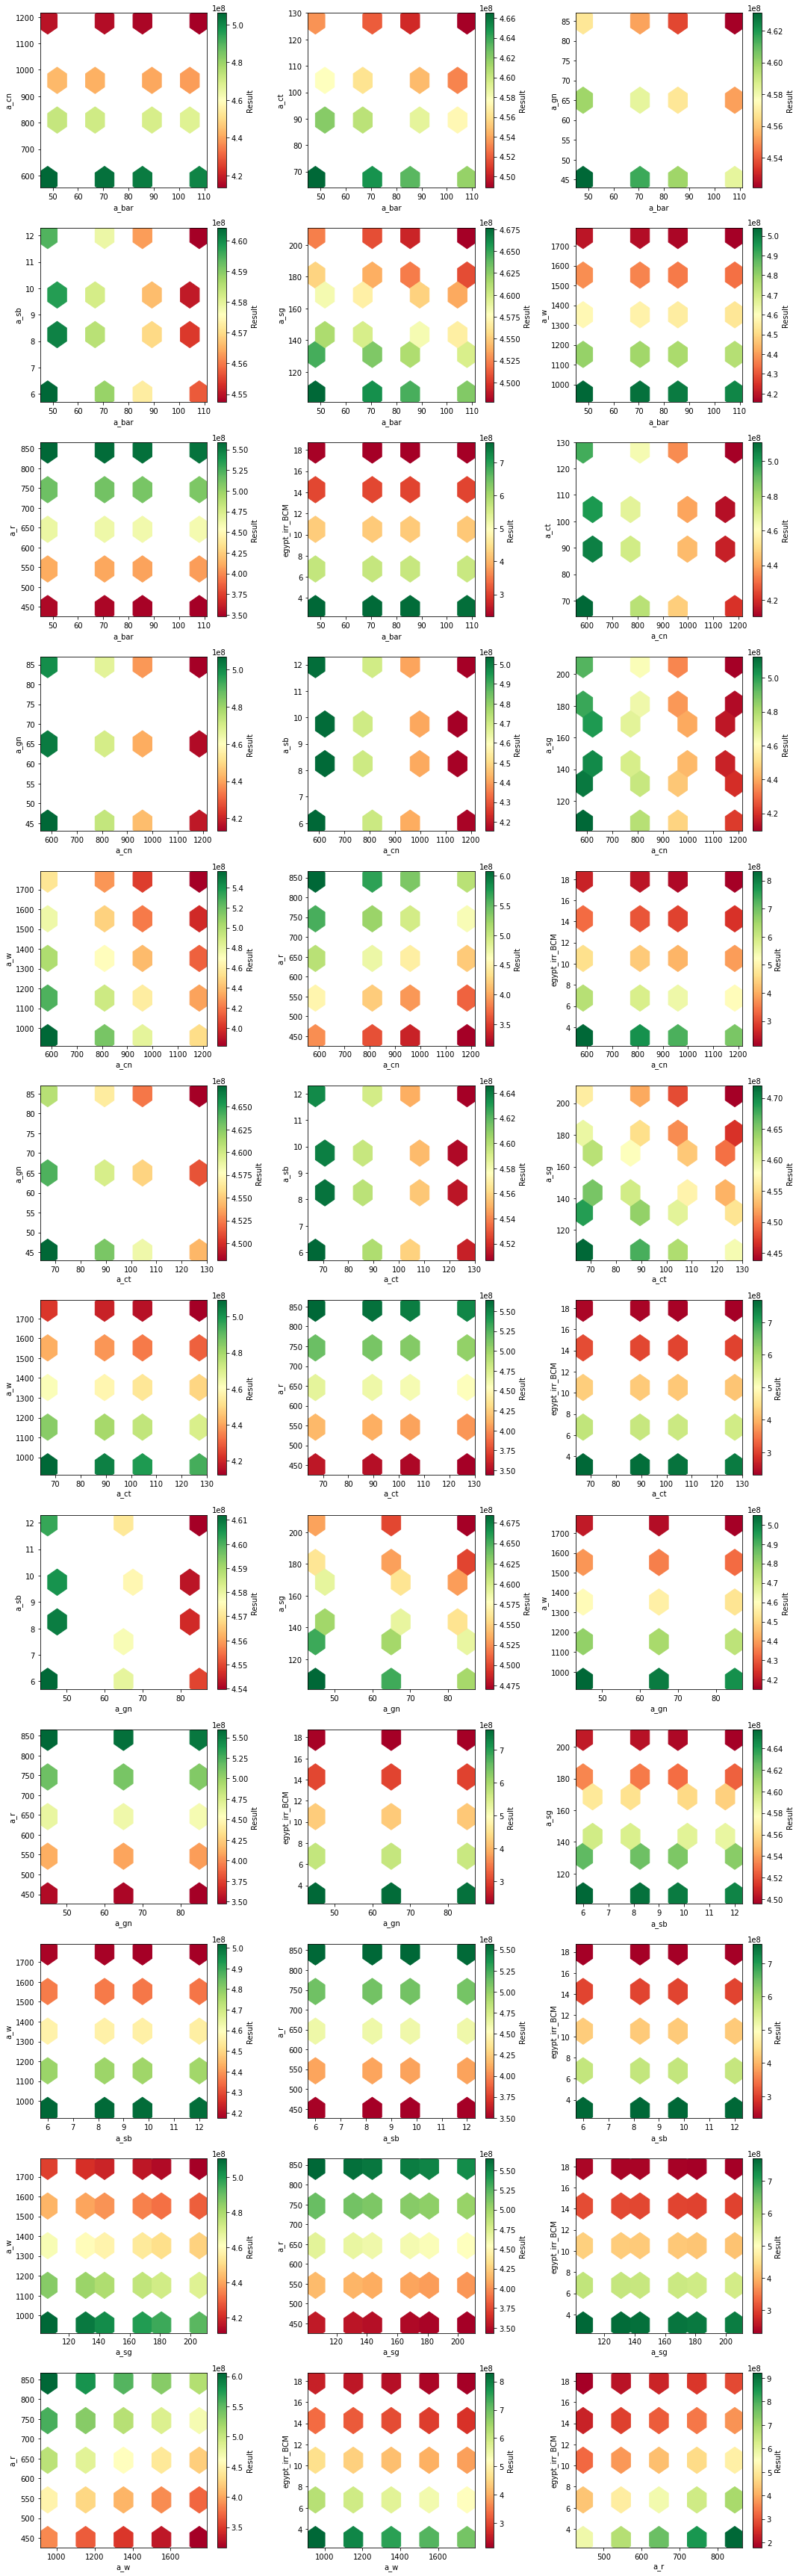

In [29]:
def EgIrrFunc(#c_bar,c_cr,c_ct,c_gn,c_sb,c_sg,c_w,c_r,
              #wu_bar,wu_cr,wu_ct,wu_gn,wu_sb,wu_sg,wu_w,wu_r,
              #y_bar,y_cr,y_ct,y_gn,y_sb,y_sg,y_w,y_r,
              a_bar,a_cn,a_ct,a_gn,a_sb,a_sg,a_w,a_r,
              egypt_irr_BCM):
    n = 20 #number of years of simulation
    dv = 0.03 #discount value of 3% for calculating FV
    base_nile_allocation = 55.5 #BCM as per Nile agreement

    egypt_irr_wo_def = (base_nile_allocation * 0.8 - egypt_irr_BCM) * 1e9
    egypt_irr_w_def = (base_nile_allocation * 0.8 + egypt_irr_BCM) * 1e9

    c_bar = 0.28  #cost for major Egyptian crops (USD/kg)
    c_cr = 0.3896
    c_ct = 0.2829
    c_gn = 4.5242
    c_sb = 0.3486
    c_sg = 0.1823
    c_w = 0.4202
    c_r = 0.2204
    
    wu_bar = 0.4857  #water efficiency for each crop (m^3/m^2)
    wu_cr = 0.9081
    wu_ct = 1.3312
    wu_gn = 0.9679
    wu_sb = 1.0083
    wu_sg = 0.9410
    wu_w = 0.6493
    wu_r = 1.2381
    
    y_bar = 0.1179 #yield for each crop (kg/m^2)
    y_cr = 0.7257
    y_ct = 0.0714
    y_gn = 0.2902
    y_sb = 0.2540
    y_sg = 0.4627
    y_w = 0.5806
    y_r = 0.7620

    #calculations for finding water ratios
    #areas for cultivation (1000 ha)
    #a_bar = 83
    #a_cr = 836
    #a_ct = 96
    #a_gn = 64
    #a_sb = 9
    #a_sg = 151
    #a_w = 1360
    #a_r = 637
    
    cost_list = [c_bar,c_cr,c_ct,c_gn,c_sb,c_sg,c_w,c_r]
    wu_list = [wu_bar,wu_cr,wu_ct,wu_gn,wu_sb,wu_sg,wu_w,wu_r]
    yield_list = [y_bar,y_cr,y_ct,y_gn,y_sb,y_sg,y_w,y_r]
    area_list = [a_bar,a_cn,a_ct,a_gn,a_sb,a_sg,a_w,a_r]
    
    wr_list = []
    for i in range(len(area_list)):
        wr = area_list[i] * 1e7 * wu_list[i]
        wr_list.append(wr)
    wr_sum = sum(wr_list)

    rat_list = []
    for i in range(len(wr_list)):
        rat = wr_list[i] / wr_sum
        rat_list.append(rat)
    
    water_all_list = []
    for i in range(len(rat_list)):
        water_all = egypt_irr_wo_def * rat_list[i]
        water_all_list.append(water_all)

    income_egypt_irr = []
    for i in range(len(water_all_list)):
        value = (cost_list[i] * yield_list[i] * water_all_list[i] / wu_list[i]) * (egypt_irr_wo_def / 
                                                                                   egypt_irr_w_def) * (1/(1 + dv) ** n)
    income_egypt_irr.append(value)
    
    total_cost = sum(income_egypt_irr)
    return total_cost

sensitivity_dict_eg_irr = {
    'a_bar': [48,68,88,108],
    'a_cn': [585,785,985,1185],
    'a_ct': [67,87,107,127],
    'a_gn': [45,65,85],
    'a_sb': [6,8,10,12],
    'a_sg': [106,126,146,166,186,206],
    'a_w': [952,1152,1352,1552,1752],
    'a_r': [446,546,646,746,846],
    'egypt_irr_BCM': [3,7,11,15,18]
}
"""     
    'c_bar': [0.19,0.22,0.25,0.28,0.31,0.34],
    'c_cr': [0.27,0.37,0.47,0.57],
    'c_ct': [0.19,0.2426,0.2958,0.35],
    'c_gn': [3.16,3.66,4.16,4.66,5.16,5.66],
    'c_sb': [0.24,0.34,0.44,0.54],
    'c_sg': [0.13,0.18,0.24],
    'c_w': [0.29,0.39,0.49,0.54],
    'c_r': [0.15,0.21,0.27,0.30],
    'wu_bar': [0.34,0.44,0.54,0.64],
    'wu_cr': [0.63,0.83,1.03,1.23],
    'wu_ct': [0.93,1.13,1.33,1.53,1.73],
    'wu_gn': [0.68,0.88,1.08,1.28],
    'wu_sb': [0.7,0.9,1.1,1.3],
    'wu_sg': [0.65,0.85,1.05,1.25],
    'wu_w': [0.45,0.55,0.65,0.75,0.85],
    'wu_r': [0.86,1.06,1.26,1.46,1.66],
    'y_bar': [0.08,0.12,0.16],
    'y_cr': [0.5,0.7,0.9],
    'y_ct': [0.04,0.06,0.08],
    'y_gn': [0.203,0.26,0.32,0.38],
    'y_sb': [0.177,0.23,0.29,0.35],
    'y_sg': [0.323,0.38,0.44,0.5,0.56],
    'y_w': [0.406,0.56,0.72,0.76],
    'y_r': [0.533,0.73,0.93,0.98], 
    """

sa = SensitivityAnalyzer(sensitivity_dict_eg_irr, EgIrrFunc)
plot = sa.plot()
#styled_df = sa.styled_dfs();

##### 2. Analysis for Sudan Utility Function 

100%|██████████| 11520/11520 [00:04<00:00, 2323.82it/s]


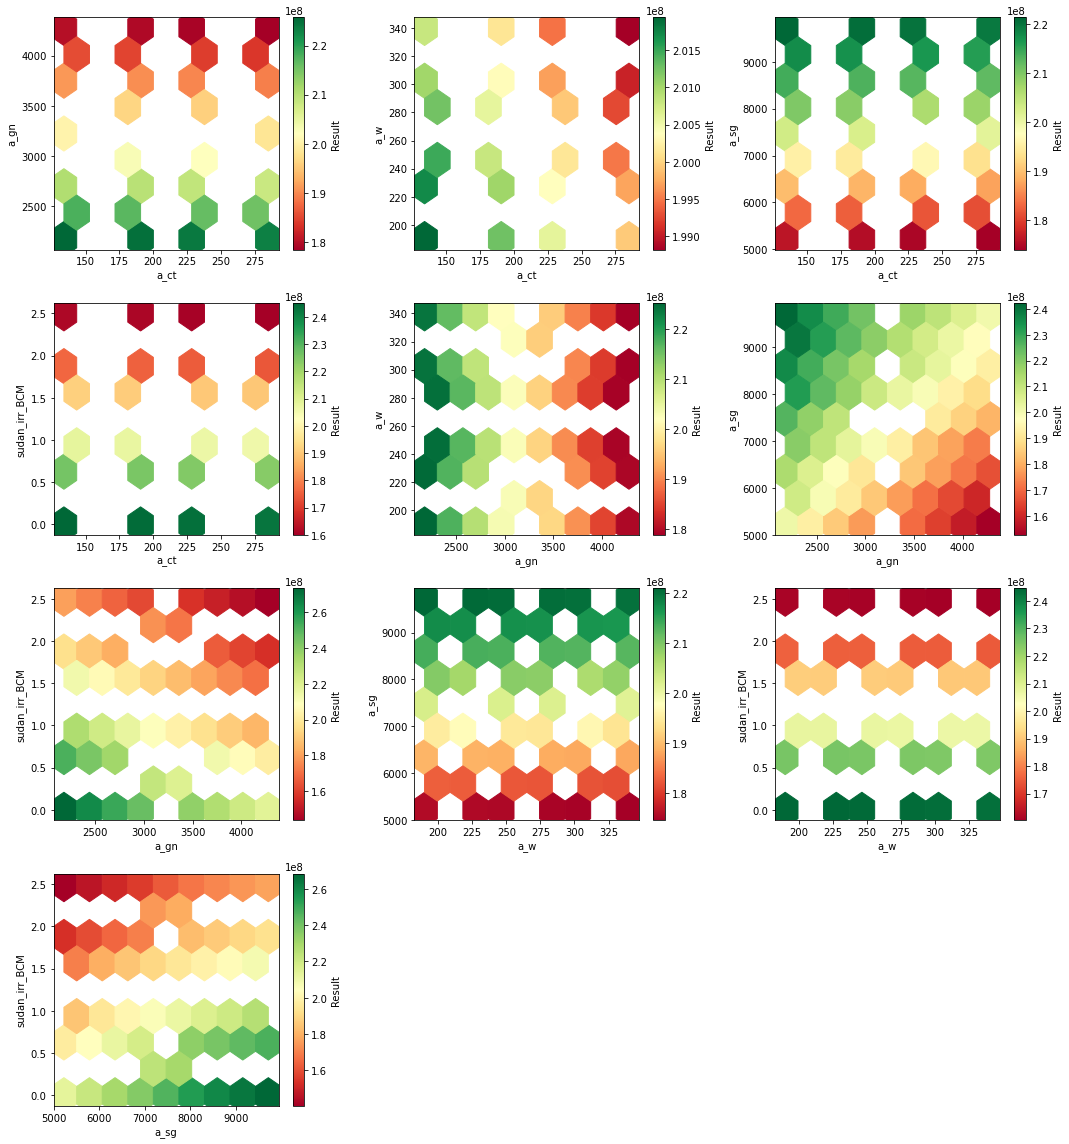

In [40]:
def SuIrrfunc(#c_ct,c_gn,c_w,c_sg,
              #wu_ct,wu_gn,wu_w,wu_sg,
              #y_ct,y_gn,y_w,y_sg,
              a_ct,a_gn,a_w,a_sg,
              sudan_irr_BCM):
    n = 20 #number of years of simulation
    dv = 0.03 #discount value of 3% for calculating FV
    base_allocation = 18.5 #BCM as per Nile agreement

    sudan_irr_wo_def = (base_allocation - sudan_irr_BCM) * 1e9
    sudan_irr_w_def = (base_allocation+ sudan_irr_BCM) * 1e9
    
    c_ct = 0.6173 #cost for major Sudanese crops (USD/kg)
    c_gn = 0.6465
    c_w = 0.7781
    c_sg = 0.5646

    wu_ct = 0.62 #water efficiency for each crop (m^3/m^2)
    wu_gn = 1.02
    wu_w = 0.355
    wu_sg = 0.815
    
    y_ct = 0.0569 #yield of crops (kg/m^2)
    y_gn = 0.0725
    y_w = 0.2177
    y_sg = 0.0544

    #a_ct = 192
    #a_gn = 3109
    #a_w = 269
    #a_sg = 7460

    cost_list = [c_ct,c_gn,c_w,c_sg]
    wu_list = [wu_ct,wu_gn,wu_w,wu_sg]
    yield_list = [y_ct,y_gn,y_w,y_sg]
    area_list = [a_ct,a_gn,a_w,a_sg]

    wr_list = []
    for i in range(len(area_list)):
        wr = area_list[i] * 1e7 * wu_list[i]
        wr_list.append(wr)
    wr_sum = sum(wr_list)

    rat_list = []
    for i in range(len(wr_list)):
        rat = wr_list[i] / wr_sum
        rat_list.append(rat)
    
    water_all_list = []
    for i in range(len(rat_list)):
        water_all = sudan_irr_wo_def * rat_list[i]
        water_all_list.append(water_all)

    income_sudan_irr = []
    for i in range(len(water_all_list)):
        value = (cost_list[i] * yield_list[i] * water_all_list[i] / wu_list[i]) * (sudan_irr_wo_def / 
                                                                                   sudan_irr_w_def) * (1/(1 + dv) ** n)
    income_sudan_irr.append(value)
    
    total_cost = sum(income_sudan_irr)

    return total_cost

sensitivity_dict_su_irr = {
    'a_ct': [134,185,235,285],
    'a_gn': [2176,2476,2776,3076,3376,3676,3976,4276],
    'a_w': [190,220,250,280,310,340],
    'a_sg':[5220,5720,6220,6720,7220,7720,8220,8720,9220,9720],
    'sudan_irr_BCM':[0,0.5,1,1.5,2,2.5]
}
'''
    'c_ct': [0.432,0.532,0.632,0.732,0.832],
    'c_gn': [0.4525,0.5525,0.6525,0.7525,0.8525],
    'c_w': [0.544,0.64,0.74,0.84,0.94,1.04],
    'c_sg': [0.395,0.49,0.59,0.69,0.79],
    'wu_ct': [0.4,0.5,0.6,0.7,0.8],
    'wu_gn': [0.7,0.8,0.9,1.0,1.1,1.2],
    'wu_w': [0.2485,0.3,0.35,0.4,0.45],
    'wu_sg':[0.57,0.67,0.77,0.87,0.97,1.07],
    'y_ct': [0.03,0.04,0.05,0.06,0.07],
    'y_gn': [0.05,0.06,0.07,0.08,0.09],
    'y_w': [0.15,0.2,0.25,0.30],
    'y_sg':[0.038,0.05,0.06,0.07],
    
'''

sa = SensitivityAnalyzer(sensitivity_dict_su_irr, SuIrrfunc)
plot = sa.plot()
#styled_df = sa.styled_dfs();

##### 3. Analysis for Ethiopia Utility Function

100%|██████████| 53240/53240 [00:25<00:00, 2109.01it/s]


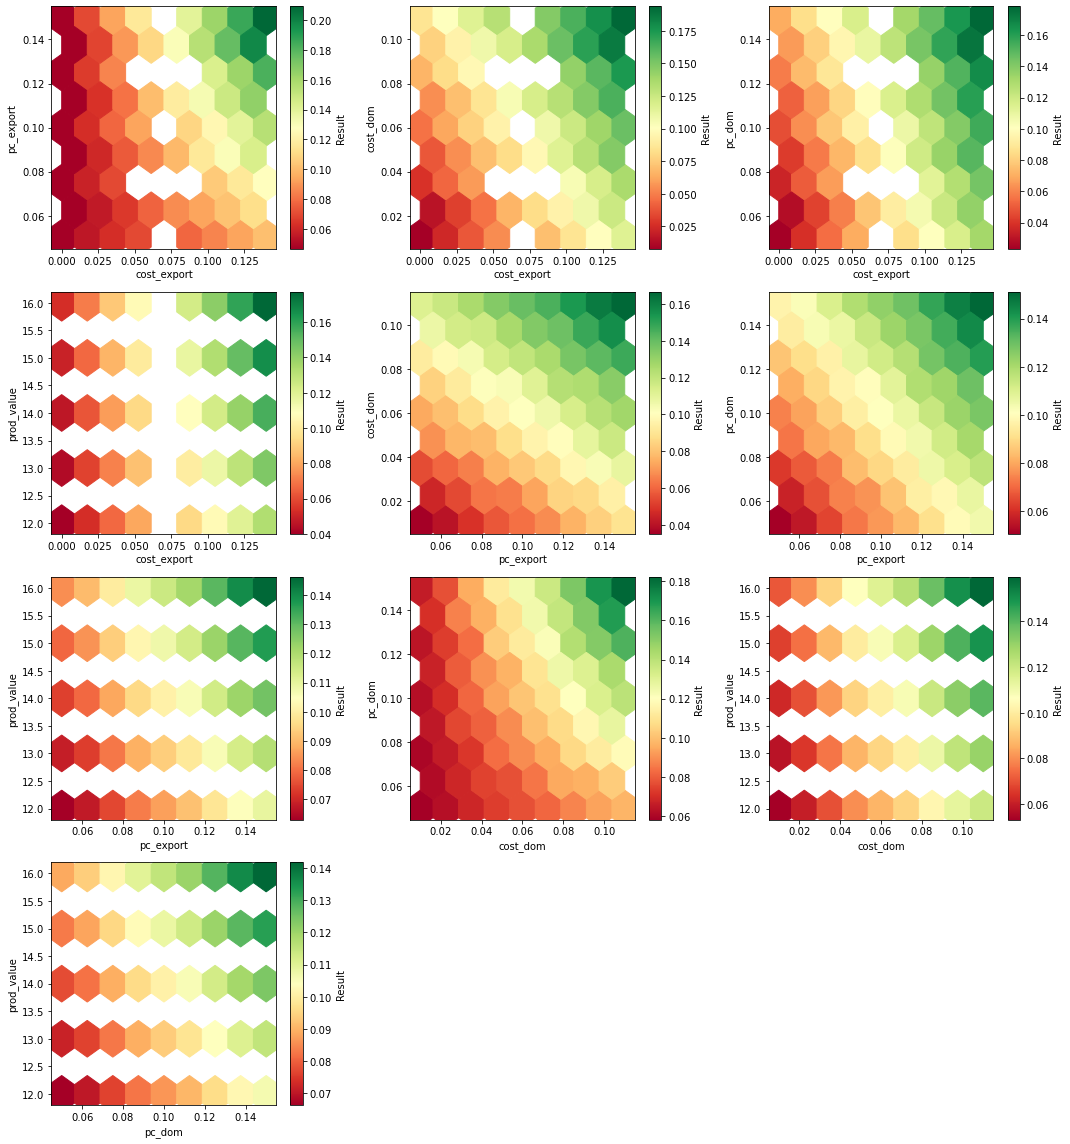

In [36]:
def EtGERDfuc(cost_export,pc_export,cost_dom,pc_dom,prod_value): #return function
    n = 20 #number of years of simulation
    dv = 0.03 #discount value of 3% for calculating FV
    return (1 / (1 + dv) ** n) * ((pc_export * prod_value * cost_export) + 
                                                pc_dom * prod_value * cost_dom)

sensitivity_dict_et = {
    'cost_export': [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14],
    'pc_export': [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15],
    'cost_dom': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11],
    'pc_dom': [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15],
    'prod_value': [12,13,14,15,16]
}

sa = SensitivityAnalyzer(sensitivity_dict_et, EtGERDfuc)
plot = sa.plot()
#styled_df = sa.styled_dfs();

#### **Steps shown below**: 
##### 1. Import and separate the baseline optimization results. 
##### 2. Use the utility conversion functions to convert optimized objectives to monetary utility. 
- Note that all outcomes have been converted to income with units of [USD/year], where the goal for all three players is to maximize their utility. This will also dictate preferences between the different policies that have been generated through following the EMODPS framework in Sari (2022). 
- Look at **util_coversion.py** function file for further explanations. 
##### 3. Characteristic value functions were determined for each possible coalition in the game.
- This was done by searching the policy space and trying to find the maximum possible value of income that can be achieved for each coalition.

##### 4. The Core was determined through marginal contribution calculations, based on the cumulative value of the grand coalition.

In [6]:
#import baseline optimization results
optimization_results = pd.read_csv("../outputs/baseline_results.csv").drop(columns="Unnamed: 0")
optimization_results

v0        v1        v2        v3        v4        v5        v6  \
0    0.000513  0.114183  0.379610  0.222861 -0.912948  0.452649  0.260217   
1    0.005551  0.114852  0.416813  0.215447 -0.673022  0.456056 -0.329024   
2    0.005551  0.114852  0.416813  0.215447 -0.673022  0.456056 -0.318718   
3    0.005551  0.088394  0.579024  0.310944  0.901105  0.007324 -0.289949   
4    0.022721  0.114852  0.416813  0.206873 -0.673022  0.456056 -0.318718   
..        ...       ...       ...       ...       ...       ...       ...   
552  0.326885  0.106877  0.545884  0.336976 -0.668031  0.437772 -0.419885   
553  0.000151  0.028225  0.393737  0.309436 -0.742859  0.191598 -0.376609   
554  0.003841  0.024536  0.447966  0.306452 -0.846223  0.457366 -0.377002   
555  0.001132  0.022049  0.478721  0.308261 -0.747247  0.411032 -0.360748   
556  0.000151  0.028225  0.393737  0.309436 -0.742859  0.191598 -0.376609   

           v7        v8        v9  ...      v160      v161      v162  \
0    0.235133 -0.412399  0.729811  ...  0.361710  0.359652  0.515373   
1    0.234759 -0.018857  0.743872  ...  0.359905  0.096117  0.525507   
2    0.234759 -0.018857  0.743872  ...  0.359905  0.096117  0.706763   
3    0.234686  0.478925  0.421958  ...  0.361385  0.315424  0.521779   
4    0.234759 -0.036241  0.744584  ...  0.386367  0.096117  0.706763   
..        ...       ...       ...  ...       ...       ...       ...   
552  0.869253  0.461072  0.744024  ...  0.376803  0.188286  0.282503   
553  0.230249 -0.751094  0.744065  ...  0.096033  0.027555  0.114251   
554  0.209600  0.481661  0.699339  ...  0.365742  0.065873  0.279207   
555  0.344056 -0.199549  0.360655  ...  0.397008  0.144051  0.298246   
556  0.233875 -0.751094  0.744065  ...  0.096033  0.068354  0.114251   

         v163  egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
0    0.375135   5.583528  1.079809       0.541667   0.027608       0.0   
1    0.365050   4.889959  1.355717       0.245833   0.000000       0.0   
2    0.365144   4.668365  1.237320       0.295833   0.000000       0.0   
3    0.395253   8.227111  2.286887       0.012500   0.067783       0.0   
4    0.365144   5.078874  0.863157       0.570833   0.008685       0.0   
..        ...        ...       ...            ...        ...       ...   
552  0.385069   4.992584  0.440134       0.558333   0.087050       0.0   
553  0.397327   4.692767  1.185513       0.633333   0.395626       0.0   
554  0.346387   4.654900  1.393756       0.470833   0.275966       0.0   
555  0.425433   7.540867  1.966258       0.016667   0.362593       0.0   
556  0.397327   4.705627  1.173453       0.637500   0.391764       0.0   

     ethiopia_hydro  
0         14.418962  
1         14.473707  
2         14.373276  
3         15.000933  
4         13.695218  
..              ...  
552       11.162882  
553       15.055595  
554       15.042024  
555       15.062063  
556       15.055337  

[557 rows x 170 columns]

In [7]:
#separate out the policy variables with the objective values
policies, objectives = optimization_results.iloc[:, :-6], optimization_results.iloc[:, -6:]

In [8]:
objectives.describe()

egypt_irr    egypt_90  egypt_low_had   sudan_irr    sudan_90  \
count  557.000000  557.000000     557.000000  557.000000  557.000000   
mean     5.661273    1.336727       0.314684    0.190269    0.026025   
std      1.995637    0.606072       0.221348    0.286749    0.083750   
min      3.288710    0.360110       0.000000    0.000000    0.000000   
25%      4.611484    1.010379       0.120833    0.000000    0.000000   
50%      5.125494    1.264032       0.304167    0.080306    0.000000   
75%      6.014132    1.505690       0.475000    0.280558    0.000000   
max     18.508088    4.538554       0.829167    1.633497    0.582877   

       ethiopia_hydro  
count      557.000000  
mean        13.901316  
std          1.399777  
min         10.648433  
25%         13.062857  
50%         14.503303  
75%         15.037574  
max         15.131309

In [9]:
#convert relevant objectives to list for utility conversion
egypt_irr_list = objectives['egypt_irr'].values.tolist()
egypt_HAD_list = objectives['egypt_low_had'].values.tolist()
sudan_irr_list = objectives['sudan_irr'].values.tolist()
ethiopia_hp_list = objectives['ethiopia_hydro'].values.tolist()

eth_utility_per_policy = [EthUtil(i) for i in ethiopia_hp_list]
sud_utility_per_policy = [SudanUtil(i) for i in sudan_irr_list]
egy_utility_irr_per_policy = [EgyptUtil(i) for i in egypt_irr_list]
egy_utility_HAD_per_policy = [egypt_HAD_util(i) for i in egypt_HAD_list]

#combine deficits to form EgyptDeficit (Utility value)
result_egypt_utility = [sum(i) for i in zip(egy_utility_HAD_per_policy,egy_utility_irr_per_policy)]

#append to original dataframe for further analysis
objectives = objectives.assign(EgyptIncome = result_egypt_utility,SudanIncome = sud_utility_per_policy,EthiopiaUtility = eth_utility_per_policy)

In [10]:
objectives.describe()

egypt_irr    egypt_90  egypt_low_had   sudan_irr    sudan_90  \
count  557.000000  557.000000     557.000000  557.000000  557.000000   
mean     5.661273    1.336727       0.314684    0.190269    0.026025   
std      1.995637    0.606072       0.221348    0.286749    0.083750   
min      3.288710    0.360110       0.000000    0.000000    0.000000   
25%      4.611484    1.010379       0.120833    0.000000    0.000000   
50%      5.125494    1.264032       0.304167    0.080306    0.000000   
75%      6.014132    1.505690       0.475000    0.280558    0.000000   
max     18.508088    4.538554       0.829167    1.633497    0.582877   

       ethiopia_hydro   EgyptIncome   SudanIncome  EthiopiaUtility  
count      557.000000  5.570000e+02  5.570000e+02     5.570000e+02  
mean        13.901316  5.001558e+09  4.530392e+08     4.310220e+08  
std          1.399777  5.116892e+08  1.355537e+07     4.340128e+07  
min         10.648433  2.184772e+09  3.872364e+08     3.301636e+08  
25%         13.062857  4.887402e+09  4.484324e+08     4.050249e+08  
50%         14.503303  5.115557e+09  4.582473e+08     4.496871e+08  
75%         15.037574  5.272400e+09  4.622430e+08     4.662526e+08  
max         15.131309  5.885956e+09  4.622430e+08     4.691590e+08

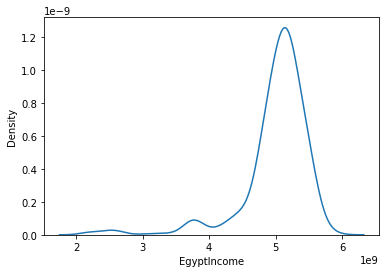

In [11]:
x_egypt = sns.kdeplot(objectives.EgyptIncome)

In [12]:
data = x_egypt.lines[0].get_xydata()
data[np.where(data[:, 1] == max(data[:, 1]))]

array([[5.12574417e+09, 1.25433217e-09]])

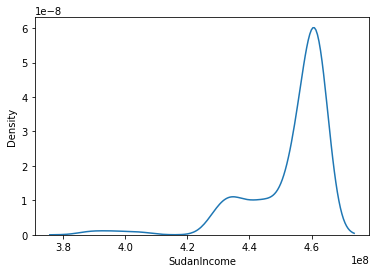

In [13]:
x_sudan = sns.kdeplot(objectives.SudanIncome)

In [14]:
data = x_sudan.lines[0].get_xydata()
data[np.where(data[:, 1] == max(data[:, 1]))]

array([[4.60925711e+08, 6.01244581e-08]])

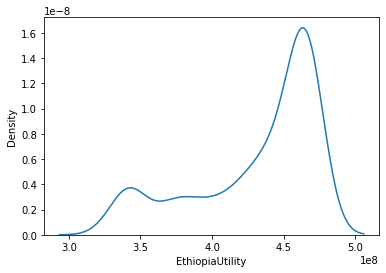

In [15]:
x_ethiopia = sns.kdeplot(objectives.EthiopiaUtility)

In [16]:
data = x_ethiopia.lines[0].get_xydata()
data[np.where(data[:, 1] == max(data[:, 1]))]

array([[4.63206226e+08, 1.64121635e-08]])

In [17]:
#finding peak density values from above as worth functions 
worth_ethiopia = 4.63206226e+08
worth_egypt = 5.12574417e+09
worth_sudan = 4.60925711e+08

ind_coalition_sum_EgSu = worth_egypt + worth_sudan
ind_coalition_sum_EgEt = worth_egypt + worth_ethiopia
ind_coalition_sum_EtSu = worth_ethiopia + worth_sudan

objectives['max_EgSu'] = objectives['EgyptIncome'] + objectives['SudanIncome']
objectives['max_EgEt'] = objectives['EgyptIncome'] + objectives['EthiopiaUtility']
objectives['max_EtSu'] = objectives['EthiopiaUtility'] + objectives['SudanIncome']

In [18]:
objectives.describe()

egypt_irr    egypt_90  egypt_low_had   sudan_irr    sudan_90  \
count  557.000000  557.000000     557.000000  557.000000  557.000000   
mean     5.661273    1.336727       0.314684    0.190269    0.026025   
std      1.995637    0.606072       0.221348    0.286749    0.083750   
min      3.288710    0.360110       0.000000    0.000000    0.000000   
25%      4.611484    1.010379       0.120833    0.000000    0.000000   
50%      5.125494    1.264032       0.304167    0.080306    0.000000   
75%      6.014132    1.505690       0.475000    0.280558    0.000000   
max     18.508088    4.538554       0.829167    1.633497    0.582877   

       ethiopia_hydro   EgyptIncome   SudanIncome  EthiopiaUtility  \
count      557.000000  5.570000e+02  5.570000e+02     5.570000e+02   
mean        13.901316  5.001558e+09  4.530392e+08     4.310220e+08   
std          1.399777  5.116892e+08  1.355537e+07     4.340128e+07   
min         10.648433  2.184772e+09  3.872364e+08     3.301636e+08   
25%         13.062857  4.887402e+09  4.484324e+08     4.050249e+08   
50%         14.503303  5.115557e+09  4.582473e+08     4.496871e+08   
75%         15.037574  5.272400e+09  4.622430e+08     4.662526e+08   
max         15.131309  5.885956e+09  4.622430e+08     4.691590e+08   

           max_EgSu      max_EgEt      max_EtSu  
count  5.570000e+02  5.570000e+02  5.570000e+02  
mean   5.454597e+09  5.432580e+09  8.840612e+08  
std    5.170811e+08  4.973536e+08  4.294648e+07  
min    2.620019e+09  2.653212e+09  7.694313e+08  
25%    5.342610e+09  5.327470e+09  8.672644e+08  
50%    5.564515e+09  5.557843e+09  9.019473e+08  
75%    5.727268e+09  5.700597e+09  9.149391e+08  
max    6.344068e+09  6.223809e+09  9.259189e+08

In [19]:
result_EgSu = objectives[objectives['max_EgSu'] >= ind_coalition_sum_EgSu].sort_values('max_EgSu', ascending=False)

if len(result_EgSu) > 0:
    result_EgSu = result_EgSu.iloc[0]
else:
    # Handle case where there are no rows with row_sum >= max_sum
    # For example, you can set result to None
    result_EgSu = None

print(result_EgSu)

egypt_irr          3.288710e+00
egypt_90           7.783319e-01
egypt_low_had      1.666667e-01
sudan_irr          8.303526e-02
sudan_90           0.000000e+00
ethiopia_hydro     1.089644e+01
EgyptIncome        5.885956e+09
SudanIncome        4.581121e+08
EthiopiaUtility    3.378534e+08
max_EgSu           6.344068e+09
max_EgEt           6.223809e+09
max_EtSu           7.959655e+08
Name: 483, dtype: float64


In [26]:
result_EgEt = objectives[objectives['max_EgEt'] >= ind_coalition_sum_EgEt].sort_values('max_EgEt', ascending=False)

if len(result_EgEt) > 0:
    result_EgEt = result_EgEt.iloc[0]
else:
    # Handle case where there are no rows with row_sum >= max_sum
    # For example, you can set result to None
    result_EgEt = None

print(result_EgEt)

egypt_irr          3.288710e+00
egypt_90           7.783319e-01
egypt_low_had      1.666667e-01
sudan_irr          8.303526e-02
sudan_90           0.000000e+00
ethiopia_hydro     1.089644e+01
EgyptIncome        5.885956e+09
SudanIncome        4.581121e+08
EthiopiaUtility    3.378534e+08
max_EgSu           6.344068e+09
max_EgEt           6.223809e+09
max_EtSu           7.959655e+08
grand_coalition    6.681922e+09
Name: 483, dtype: float64


In [20]:
result_EtSu = objectives[objectives['max_EtSu'] >= ind_coalition_sum_EtSu].sort_values('max_EtSu', ascending=False)

if len(result_EtSu) > 0:
    result_EtSu = result_EtSu.iloc[0]
else:
    # Handle case where there are no rows with row_sum >= max_sum
    # For example, you can set result to None
    result_EtSu = None

print(result_EtSu)

egypt_irr          9.046920e+00
egypt_90           2.276373e+00
egypt_low_had      8.333333e-03
sudan_irr          5.614726e-02
sudan_90           0.000000e+00
ethiopia_hydro     1.504469e+01
EgyptIncome        4.128292e+09
SudanIncome        4.594457e+08
EthiopiaUtility    4.664731e+08
max_EgSu           4.587738e+09
max_EgEt           4.594766e+09
max_EtSu           9.259189e+08
Name: 301, dtype: float64


In [21]:
grand_coalition_worth = worth_egypt + worth_ethiopia + worth_sudan
objectives['grand_coalition'] = objectives['EgyptIncome'] + objectives['SudanIncome'] + objectives['EthiopiaUtility']

In [22]:
result_gc = objectives[objectives['grand_coalition'] >= grand_coalition_worth].sort_values('grand_coalition', ascending=False)

if len(result_gc) > 0:
    result_gc = result_gc.iloc[0]
else:
    # Handle case where there are no rows with row_sum >= max_sum
    # For example, you can set result to None
    result_gc = None

print(result_gc)

egypt_irr          3.288710e+00
egypt_90           7.783319e-01
egypt_low_had      1.666667e-01
sudan_irr          8.303526e-02
sudan_90           0.000000e+00
ethiopia_hydro     1.089644e+01
EgyptIncome        5.885956e+09
SudanIncome        4.581121e+08
EthiopiaUtility    3.378534e+08
max_EgSu           6.344068e+09
max_EgEt           6.223809e+09
max_EtSu           7.959655e+08
grand_coalition    6.681922e+09
Name: 483, dtype: float64


#### **Utility Conversion to Payoffs**
- Each of the policies in the optimized list, when added together after the conversion to utility, does not add up to the value of the grand coalition. 
Therefore, a scaling factor is added to each output to scale each country's utility, with original weights implemented, to ensure that the grand coalition worth is reached. 
- Furthermore, due the magnitude of these values, they will be scaled down by 10^{9} for ease of understanding. 

In [23]:
def utility_scaler(payoff_vector):
    target_val = objectives['grand_coalition'].max()
    normalizer = target_val / float( sum(payoff_vector) )
    numListNormalized = [allocation * normalizer for allocation in payoff_vector]
    return numListNormalized

for index,row in objectives.iterrows():
    payoff_vector = row[6:9].tolist()

    scaled_payoff = utility_scaler(payoff_vector)

    objectives.at[index,'EgyptIncome'] = scaled_payoff[0]
    objectives.at[index,'SudanIncome'] = scaled_payoff[1]
    objectives.at[index,'EthiopiaUtility'] = scaled_payoff[2]

In [24]:
objectives

egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  ethiopia_hydro  \
0     5.583528  1.079809       0.541667   0.027608       0.0       14.418962   
1     4.889959  1.355717       0.245833   0.000000       0.0       14.473707   
2     4.668365  1.237320       0.295833   0.000000       0.0       14.373276   
3     8.227111  2.286887       0.012500   0.067783       0.0       15.000933   
4     5.078874  0.863157       0.570833   0.008685       0.0       13.695218   
..         ...       ...            ...        ...       ...             ...   
552   4.992584  0.440134       0.558333   0.087050       0.0       11.162882   
553   4.692767  1.185513       0.633333   0.395626       0.0       15.055595   
554   4.654900  1.393756       0.470833   0.275966       0.0       15.042024   
555   7.540867  1.966258       0.016667   0.362593       0.0       15.062063   
556   4.705627  1.173453       0.637500   0.391764       0.0       15.055337   

      EgyptIncome   SudanIncome  EthiopiaUtility      max_EgSu      max_EgEt  \
0    5.631499e+09  5.331901e+08     5.172321e+08  5.328479e+09  5.314686e+09   
1    5.696287e+09  5.001057e+08     4.855285e+08  5.727268e+09  5.713794e+09   
2    5.706897e+09  4.964190e+08     4.786051e+08  5.776249e+09  5.759661e+09   
3    5.511777e+09  5.811157e+08     5.890288e+08  4.811149e+09  4.817398e+09   
4    5.679182e+09  5.223974e+08     4.803424e+08  5.482313e+09  5.445136e+09   
..            ...           ...              ...           ...           ...   
552  5.765256e+09  5.220634e+08     3.946025e+08  5.514746e+09  5.402947e+09   
553  5.673597e+09  4.909030e+08     5.174217e+08  5.561535e+09  5.585460e+09   
554  5.685602e+09  4.885045e+08     5.078153e+08  5.670458e+09  5.688194e+09   
555  5.566334e+09  5.439999e+08     5.715874e+08  4.992411e+09  5.014951e+09   
556  5.672295e+09  4.916464e+08     5.179799e+08  5.554944e+09  5.578675e+09   

         max_EtSu  grand_coalition  
0    9.079375e+08     5.775551e+09  
1    9.110125e+08     6.176038e+09  
2    9.078986e+08     6.221904e+09  
3    9.239847e+08     5.276266e+09  
4    8.864410e+08     5.906945e+09  
..            ...              ...  
552  8.040279e+08     5.860860e+09  
553  9.096981e+08     6.028347e+09  
554  9.150457e+08     6.136849e+09  
555  9.114837e+08     5.459423e+09  
556  9.098751e+08     6.021747e+09  

[557 rows x 13 columns]

In [25]:
objectives['EgyptIncome'] = objectives['EgyptIncome'] / 1e9
objectives['SudanIncome'] = objectives['SudanIncome'] / 1e9
objectives['EthiopiaUtility'] = objectives['EthiopiaUtility'] / 1e9

In [26]:
#save dataframe for further analysis
objectives.to_csv('objectives_utility.csv')

### Plotting the Core:

In [27]:
unique_coalitions = ['Null',
 'Egypt',
 'Sudan',
 'Ethiopia',
 'Egypt Sudan',
 'Egypt Ethiopia',
 'Sudan Ethiopia',
 'Egypt Sudan Ethiopia']

unique_coalitions_char_values = [0.0,
 5.124744170,
 0.460925711,
 0.463206226,
 6.344068,
 6.223809,
 0.9259189,
 6.681922]

In [28]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

# Set notebook mode to work in offline
pyo.init_notebook_mode()

#points = np.array([()])
#A, B, C = points.T
fig = px.scatter_ternary()

t_low1 = [5.12574417, 5.12574417,5.88314229, 5.88314229]
l_low1 = [1.55617783, 0,0,0.798778]
r_low1 = [0, 1.55617783,0.798778,0]
#t_high1 = [6.25507929, 6.25507929]
#l_high1 = [0.798778, 0]
#r_high1 = [0, 0.798778]

fig.add_scatterternary(a=t_low1,b=l_low1,c=r_low1,name="Egypt MC Boundary",mode='lines', fill="toself")
#fig.add_scatterternary(a=t_high1, b=l_high1,c =r_high1, name = "Egypt High Boundary")

t_low2 = [0,6.344068,5.5838,0]
l_low2 = [0.337854,0.337854,1.09806483,1.09806483]
r_low2 = [6.344068,0,0,5.5838]
#t_high2 = [0,5.8807]
#l_high2 = [1.1731468,1.1731468]
#r_high2 = [5.8807,0]

fig.add_scatterternary(a=t_low2,b=l_low2,c=r_low2,name="Ethiopia MC Boundary",mode = 'lines',fill = 'toself')
#fig.add_scatterternary(a=t_high2, b=l_high2,c =r_high2, name = "Ethiopia High Boundary")

t_low3 = [6.223809,0,0,5.463598]
l_low3 = [0,6.223809,5.463598,0]
r_low3 = [0.458113,0.458113,1.21832,1.21832]

fig.add_scatterternary(a=t_low3,b=l_low3,c=r_low3,name="Sudan MC Boundary",mode = 'lines',fill = 'toself')

fig.update_ternaries(sum=unique_coalitions_char_values[7], aaxis_min=55)
fig.update_layout(
title = 'Eastern Nile Basin Core',
ternary =
        {
        'sum':6.681922,
        'aaxis':{'title': 'Sudan', 'min': 0.01, 'linewidth':1, 'ticks':'outside' },
        'baxis':{'title': 'Egypt', 'min': 0.01, 'linewidth':1, 'ticks':'outside' },
        'caxis':{'title': 'Ethiopia', 'min': 0.01, 'linewidth':1, 'ticks':'outside' }
},
width = 900,
height = 900
)
fig.show()

/opt/anaconda3/envs/gds/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.

